# Merge the NHTS with the EPA Fuel Economy Database
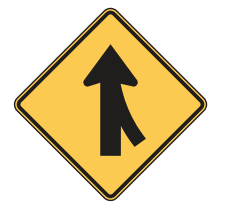

From https://www.fueleconomy.gov/feg/download.shtml

In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import re

In [85]:
# read data
# make year model so that we can fuzzy match on model below
fueleconomy = pd.read_csv('../data/fuel_economy.csv', low_memory=False)
fueleconomy['model'] = fueleconomy.model.apply(lambda x: x.lower().strip())
fueleconomy = fueleconomy.set_index(['make', 'year', 'model'], drop=False).sortlevel()
vehicles = pd.read_csv('../data/nhts/vehpub.csv')

/Users/matthewc/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)


In [86]:
vehicles['modelName'] = vehicles.MODEL.replace({
'-8': np.nan,
'-88': np.nan,
'12003': 'Mustang/Mustang II',
'12004': 'Thunderbird (all sizes)',
'12006': 'LTD/Custom/Galaxy (all sizes)',
'12013': 'Escort/EXP/ZX2',
'12016': 'Crown Victoria',
'12017': 'Taurus/Taurus X',
'12021': 'Five Hundred',
'12022': 'Freestyle',
'12023': 'Fusion',
'12024': 'Edge',
'12025': 'Flex',
'12027': 'C-Max',
'12032': 'Fiesta',
'12035': 'Contour',
'12037': 'Focus',
'12398': 'Other (automobile) Deluxe, Ford Six, Mainline,',
'12399': 'Unknown (automobile)',
'12401': 'Bronco (thru 1977)/Bronco II/Explorer/Explorer Sport',
'12402': 'Escape',
'12421': 'Bronco-full-size (1978 on)',
'12422': 'Expedition',
'12423': 'Excursion',
'12441': 'Aerostar',
'12442': 'Windstar',
'12443': 'Freestar',
'12444': 'Transit Connect',
'12461': 'E-Series Van/Econoline',
'12462': 'Transit',
'12470': 'Van Derivative',
'12471': 'Ranger',
'12473': 'Explorer Sport Trac',
'12481': 'F-Series pickup',
'12499': 'Unknown (light truck)',
'12850': 'Motor Home',
'12880': 'Medium/Heavy Pickup (pickup-style only – over 10,000 lbs.)',
'13001': 'Continental (thru 1981)/ Town Car',
'13005': 'Continental (1982 on)',
'13012': 'LS',
'13013': 'Zephyr/MKZ',
'13014': 'MKX',
'13015': 'MKS',
'13402': 'MKC',
'13421': 'Navigator',
'14004': 'Cougar (1967-1997) /XR7 (1967-1997)',
'14006': 'Marquis/Monterey (car version) /Grand Marquis',
'14017': 'Sable',
'14020': 'Montego (2005 on)',
'14021': 'Milan',
'14401': 'Mountaineer',
'14402': 'Mariner',
'14443': 'Villager',
'18002': 'LeSabre/Centurion/Wildcat',
'18003': 'Electra/Electra 225/Park Avenue (1991 on)',
'18004': 'Roadmaster',
'18005': 'Riviera',
'18007': 'Century',
'18010': 'Regal (RWD only)',
'18019': 'Regal (2011 on)',
'18020': 'Regal (FWD)',
'18022': 'LaCrosse',
'18023': 'Lucerne',
'18024': 'Enclave (2008-2012)',
'18025': 'Verano',
'18401': 'Rendezvous',
'18404': 'Encore',
'18421': 'Enclave (2013 on)',
'19003': 'Deville/Fleetwood (except Limousine)',
'19005': 'Eldorado',
'19014': 'Seville',
'19018': 'CTS/CTC',
'19020': 'SRX',
'19021': 'STS',
'19022': 'DTS',
'19023': 'XTS',
'19024': 'ATS',
'19421': 'Escalade/ESV (2004 on)',
'19480': 'Escalade EXT (2002 -2006)',
'19481': 'Escalade EXT (2007)',
'20001': 'Chevelle/Malibu (thru 1983)',
'20002': 'Impala/Caprice (2014 on)',
'20004': 'Corvette',
'20007': 'El Camino',
'20008': 'Nova (thru 1979)',
'20009': 'Camaro',
'2001': 'Compass',
'20010': 'Monte Carlo (thru 1988)',
'20016': 'Cavalier',
'20020': 'Lumina',
'20022': 'Cobalt',
'20023': 'HHR',
'20024': 'Traverse (2009-2012)',
'20025': 'Cruze',
'20026': 'Volt',
'20027': 'Caprice PPV',
'20028': 'Sonic',
'20029': 'Spark',
'20032': 'Nova/Geo Prism/Prism',
'20034': 'Geo Metro/Metro',
'20036': 'Monte Carlo (1995 on)',
'20037': 'Malibu/Malibu Maxx',
'20039': 'Aveo/Aveo 5',
'20401': 'S-10 Blazer/TrailBlazer (2002 only)',
'20402': 'Geo Tracker/Tracker',
'20403': 'TrailBlazer (2003 on)',
'20404': 'Equinox',
'20405': 'Captiva',
'20406': 'Trax',
'20421': 'Fullsize Blazer/Tahoe',
'20422': 'Suburban (2004 on)',
'20423': 'Traverse (2013 on)',
'20431': 'Suburban (1950-2003)',
'20441': 'Astro Van',
'20443': 'Venture',
'20444': 'Uplander',
'20445': 'City Express',
'20461': 'G-series van',
'20470': 'Van derivative',
'20471': 'S-10/T-10 Pickup',
'20473': 'Colorado',
'20481': 'C, K, R, V-Series pickup/Silverado',
'20482': 'Avalanche',
'20498': 'Other (light truck)',
'20499': 'Unknown (light truck)',
'20850': 'Motor Home',
'20870': 'Medium/Heavy Van-Based Vehicle',
'20880': 'Medium/Heavy Pickup (pickup-style only – over 10,000 lbs)',
'20881': 'Medium/Heavy – CBE',
'21001': 'Cutlass (RWD-only)',
'21002': 'Delta 88/LSS',
'21020': 'Cutlass (FWD)',
'21021': 'Achieva/Alero',
'21023': 'Intrigue',
'21401': 'Bravada',
'21441': 'Silhouette',
'22002': 'Bonneville/Catalina/ Parisienne',
'22009': 'Firebird/Trans AM',
'22010': 'Grand Prix (RWD)',
'22016': 'Sunbird (1985-1994) /J-2000/Sunfire (1995 on)',
'22018': 'Grand AM',
'22020': 'Grand Prix (FWD)',
'22022': 'G6',
'22023': 'Solstice',
'22032': 'Vibe',
'22403': 'Torrent',
'22441': 'Trans Sport/ Montana/SV6',
'23008': 'Acadia (2007-2012)',
'23401': 'Jimmy/Typhoon/Envoy',
'23402': 'Terrain',
'23421': 'Full-size Jimmy/Yukon',
'23422': 'Suburban/Yukon XL (2004 on)',
'23423': 'Acadia (2013 on)',
'23431': 'Suburban/Yukon XL (1950-2003 only)',
'23441': 'Safari (Minivan)',
'23461': 'G-series van/Savana',
'23471': 'S15/T15/Sonoma',
'23472': 'Canyon',
'23481': 'C, K, R, V-series pickup/Sierra',
'23499': 'Unknown (light truck)',
'23880': 'Medium/Heavy Pickup (pickup-style only – over 10,000 lbs)',
'24001': 'SL',
'24002': 'SC',
'24005': 'LS',
'24007': 'Ion',
'24009': 'Aura',
'2401': 'CJ-2/CJ-3/CJ-4',
'24010': 'Outlook',
'2402': 'CJ-5/CJ-6/CJ-7/CJ-8',
'2403': 'YJ series/Wrangler',
'2404': 'Cherokee (1984 on)',
'2405': 'Liberty',
'2406': 'Commander',
'2407': 'Patriot',
'2408': 'Renegade',
'2421': 'Cherokee (thru 1983)',
'2422': 'Grand Cherokee (2014 on)',
'24401': 'Vue',
'29005': 'Tesla',
'30032': 'Beetle 1300/1500',
'30033': 'Super Beetle',
'30036': 'Rabbit',
'30040': 'Jetta/Jetta SportsWagen',
'30042': 'Golf/Cabriolet/Cabrio/GTI/GLI',
'30046': 'Passat (CC 2008-2011)',
'30047': 'New Beetle',
'30051': 'Eos',
'30052': 'CC (2012 on)',
'30402': 'Tiguan',
'30421': 'Touareg/Touareg 2',
'30441': 'Vanagon/Camper',
'30443': 'Routan',
'32042': 'A6',
'32043': 'A4',
'32045': 'TT/TTS',
'32048': 'A3',
'32049': 'A5',
'32401': 'Q7',
'32402': 'Q5',
'3402': 'H3',
'34034': '3-series',
'34035': '5-series',
'34036': '6-series',
'34037': '7-series',
'34039': 'Z3',
'34042': 'Z4',
'34043': '1-Series',
'34047': '4-Series',
'34401': 'X5',
'34402': 'X3',
'34403': 'X1',
'34705': '450-749cc',
'34706': '750cc and over',
'35034': 'Z-car, ZX',
'35039': '810/Maxima',
'35043': 'Sentra',
'35047': 'Altima',
'35048': '350Z/370Z',
'35049': 'Murano',
'35050': 'Versa',
'35051': 'Rogue',
'35052': 'Cube',
'35055': 'Leaf',
'35401': 'Pathfinder',
'35402': 'Xterra',
'35403': 'Juke',
'35421': 'Pathfinder Armada',
'35443': 'Quest',
'35471': 'Datsun/Nissan Pickup (1955-1997)',
'35472': 'Frontier (1998 on)',
'35473': 'Titan (2004-2006)',
'35481': 'Titan (2007 on)',
'35499': 'Unknown (light truck)',
'36038': '500/500c',
'37031': 'Civic/CRX, del Sol',
'37032': 'Accord',
'37033': 'Prelude',
'37035': 'S2000',
'37037': 'Insight',
'37039': 'Fit',
'37041': 'CR-Z',
'37398': 'Other (automobile)',
'37401': 'Passport',
'37402': 'CR-V',
'37403': 'Element',
'37421': 'Pilot',
'37441': 'Odyssey',
'37471': 'Ridgeline',
'37701': 'Motorcycle 0-50 cc',
'37702': 'Motorcycle 51-124 cc',
'37703': 'Motorcycle 125-349 cc',
'37704': 'Motorcycle 350-449 cc',
'37705': 'Motorcycle 450-749 cc',
'37706': 'Motorcycle 750 cc or greater',
'37709': 'Unknown cc',
'37733': 'ATV 125-349cc',
'37734': 'ATV 350cc or greater',
'38401': 'Trooper/Trooper II',
'38402': 'Rodeo/Rodeo Sport',
'39031': 'XJ-S, XK8 Coupe',
'39032': 'XJ/XJL/XJ6/12/XJR/XJ8/XJ8L Sedan/Coupe',
'39034': 'S-Type',
'39036': 'X-Type',
'41035': '323/GLC/Protégé/ Protégé 5',
'41037': '626',
'41045': 'Miata/MX-5',
'41050': 'Mazda6',
'41051': 'Mazda3',
'41052': 'Mazda5',
'41053': 'CX-7',
'41054': 'CX-9 (2007-2012)',
'41402': 'Tribute',
'41403': 'CX-5',
'41421': 'CX-9 (2013 on)',
'41441': 'MPV',
'41471': 'Pickup/ B-Series Pickup',
'42031': '200/220/230/240/ 250/260/280/300/ 320/420',
'42032': '230/280 SL',
'42033': '300/350/380/450/500/ 560 SL',
'42034': '350/380/420/450/560 SLC',
'42036': '300/380/420/450/500/560/SEL & 500/560, 600 SEC & 300/350 SDL',
'42040': '300',
'42042': 'C Class (1994 on)',
'42043': 'S Class (1995 on)',
'42044': 'SL Class (1995 on)',
'42045': 'SLK',
'42047': 'CLK',
'42048': 'E Class (1997 on)',
'42401': 'M/ML Class',
'42403': 'GLK Class',
'42421': 'GL Class',
'42461': 'Sprinter',
'45031': '911/996',
'45040': '986/Boxster',
'45421': 'Cayenne',
'47035': '9-3/9-3x',
'47036': '9-5',
'48034': 'Legacy/Outback (thru 2003)',
'48038': 'Impreza',
'48045': 'Outback (2003 on)',
'48047': 'WRX (2015 on)',
'48401': 'Forester',
'48402': 'B9 Tribeca',
'48403': 'XV Crosstrek',
'49032': 'Corolla',
'49033': 'Celica',
'49038': 'Tercel',
'49040': 'Camry',
'49041': 'MR-2/MR Spyder',
'49043': 'Avalon',
'49044': 'Solara',
'49045': 'ECHO',
'49046': 'Prius',
'49047': 'Matrix',
'49048': 'Scion xA',
'49049': 'Scion xB (2004-2011)',
'49050': 'Scion tC (2005-2011)',
'49051': 'Yaris',
'49053': 'Venza',
'49401': '4-Runner',
'49402': 'RAV4',
'49403': 'Highlander',
'49404': 'FJ Cruiser',
'49421': 'Land Cruiser',
'49422': 'Sequoia',
'49442': 'Sienna',
'49471': 'Pickup',
'49472': 'Tacoma',
'49481': 'T-100',
'49482': 'Tundra',
'49499': 'Unknown (light truck)',
'50706': '750cc or greater',
'51034': '240 series/DL/GL/GLT',
'51042': '850',
'51043': '70 Series (1998-2013)',
'51045': '80 Series',
'51046': '40 Series',
'51047': '60 Series',
'51050': 'XC60',
'51401': 'XC90',
'51402': 'XC70 (2014 on)',
'52034': 'Galant',
'52037': 'Eclipse',
'52046': 'Lancer/Lancer Sportback/Lancer Evolution',
'52047': 'Outlander',
'52401': 'Montero/MonteroSport',
'52402': 'Endeavor',
'53034': 'Forenza',
'53040': 'SX4/SX4 Crossover',
'53404': 'Grand Vitara (2003 on)',
'53405': 'XL-7 (2003 on)',
'53704': 'Motorcycle 350-449cc',
'53705': 'Motorcycle 450-749cc',
'53706': 'Motorcycle 750cc or greater',
'54031': 'Integra',
'54032': 'Legend',
'54035': 'TL',
'54036': 'RL/RLX',
'54037': 'CL',
'54038': 'RSX',
'54039': 'TSX',
'54041': 'ILX',
'54044': 'TLX',
'54402': 'RDX',
'54421': 'MDX',
'55033': 'Sonata',
'55035': 'Elantra',
'55036': 'Accent',
'55037': 'Tiburon',
'55039': 'Azera',
'55041': 'Genesis',
'55042': 'Veloster',
'55401': 'Santa Fe',
'55402': 'Tucson',
'55421': 'Veracruz (2008 on)',
'58035': 'I30',
'58037': 'G25/G35/G37',
'58038': 'M35/M37/M45/M56',
'58039': 'FX35/FX37/FX45/FX50',
'58041': 'Q50',
'58403': 'QX60',
'58421': 'QX56',
'59031': 'ES-250/300/300h/330/ 350',
'59032': 'LS-400/430/460/L/600h/L',
'59034': 'GS-300/350/400/430/ 450h/460',
'59035': 'IS-250/300/350/500',
'59036': 'SC-430',
'59038': 'CT 200h',
'59401': 'RX300/350',
'59402': 'GX470',
'59403': 'RX330/350/400h/450h',
'59404': 'GX460',
'59405': 'NX',
'59421': 'LX450/470/570',
'6018': '200',
'6041': 'Concorde',
'6043': 'Sebring',
'6051': '300M/300/300C/300S',
'6052': 'PT Cruiser',
'6054': 'Pacifica',
'6055': 'Crossfire',
'62421': 'Range Rover',
'62423': 'LR3/LR4',
'63032': 'Rio/Rio5',
'63033': 'Spectra/Spectra5',
'63034': 'Optima',
'63035': 'Amanti',
'63036': 'Rondo',
'63037': 'Soul',
'63038': 'Forte',
'63401': 'Sportage',
'63402': 'Sorento',
'63441': 'Sedona',
'6441': 'Town and Country',
'6442': 'Voyager (2000 on)',
'65031': 'Fortwo',
'67031': 'xB (2012 on)',
'67032': 'tC (2012 on)',
'67033': 'xD (2012 on)',
'69054': 'Mini-Cooper',
'7020': 'Neon',
'7021': 'Magnum',
'7024': 'Charger (2006 on)',
'7025': 'Caliber',
'7026': 'Avenger (2008 on)',
'7027': 'Journey',
'7028': 'Challenger (2008 on)',
'7029': 'Dart (2013 on)',
'7033': 'Challenger',
'7041': 'Intrepid',
'7043': 'Stratus',
'71706': '750cc or greater',
'72706': '750cc or greater',
'73703': 'Motorcycle 125-349cc',
'73705': 'Motorcycle 450-749cc',
'73706': 'Motorcycle 750cc or greater',
'7402': 'Durango (1998-2003)',
'7403': 'Nitro',
'7422': 'Durango (2004 on)',
'7442': 'Caravan/Grand Caravan',
'7443': 'Ram C/V',
'7461': 'B-Series Van/fRam Van/Ram Wagon',
'7471': 'D50, Colt pickup, Ram 50/Ram 100',
'7472': 'Dakota',
'7481': 'D, W-Series pickup',
'7482': 'Ram Pickup',
'7499': 'Unknown (light truck)',
'76701': 'Motorcycle 0-50cc',
'76703': 'Motorcycle 125-349cc',
'76705': 'Motorcycle 450-749cc',
'76706': 'Motorcycle 750cc or greater',
'76734': 'ATV 350cc or greater',
'77706': '750cc or greater',
'7880': 'Medium/Heavy Pickup (pickup-style only – over 10,000 lbs)',
'9442': 'Voyager (minivan)',
'98701': '0-50cc',
'98703': '125-349cc',
'98705': '450-749cc',
'98706': '750cc or greater',
'98709': 'Unknown cc',
'98734': '350cc or greater',
'98739': 'Unknown cc',
'98850': 'Motor Home',
'98998': 'Other (vehicle)',
'XXXXX': 'Suppressed'
}).apply(lambda x: str(x).lower().strip()).astype('category')

vehicles['hasFullModel'] = ~vehicles.modelName.isin([
    'unknown (light truck)',
    'motorcycle 0-50cc',
    'motorcycle 450-749cc',
    'motorcycle 750cc or greater',
    '0-50cc',
    '125-349cc',
    '450-749cc',
    '750cc or greater',
    'unknown cc',
    '350cc or greater',
    'motor home',
    'medium/heavy pickup (pickup-style only – over 10,000 lbs)',
    'other (vehicle)',
    'suppressed'
])

vehicles['makeName'] = vehicles.MAKE.replace({
    '-8': np.nan,
'-88': np.nan,
'01': 'American Motors Corporation',
'02': 'Jeep',
'03': 'Hummer', # AM General in original data
'06': 'Chrysler',
'07': 'Dodge',
'09': 'Plymouth',
'12': 'Ford',
'13': 'Lincoln',
'14': 'Mercury',
'18': 'Buick',
'19': 'Cadillac',
'20': 'Chevrolet',
'21': 'Oldsmobile',
'22': 'Pontiac',
'23': 'GMC',
'24': 'Saturn',
'29': 'Other Domestic',
'30': 'Volkswagen',
'32': 'Audi',
'34': 'BMW',
'35': 'Nissan', # NB formerly Nissan/Datsun but Datsun not in EPA DB
'36': 'Fiat',
'37': 'Honda',
'38': 'Isuzu',
'39': 'Jaguar',
'41': 'Mazda',
'42': 'Mercedes-Benz',
'43': 'MG',
'45': 'Porsche',
'47': 'Saab',
'48': 'Subaru',
'49': 'Toyota',
'50': 'Triumph',
'51': 'Volvo',
'52': 'Mitsubishi',
'53': 'Suzuki',
'54': 'Acura',
'55': 'Hyundai',
'58': 'Infiniti',
'59': 'Lexus',
'62': 'Land Rover',
'63': 'Kia',
'65': 'smart',
'67': 'Scion',
'69': 'Other Import',
'71': 'Ducati',
'72': 'Harley-Davidson',
'73': 'Kawasaki',
'76': 'Yamaha',
'77': 'Victory',
'82': 'Freightliner',
'84': 'International Harvester/Navistar',
'98': 'Other',
'99': 'Unknown',
'XX': 'Suppressed'
}).astype('category')

vehicles['kind'] = vehicles.VEHTYPE.replace({
    -7: np.nan,
    -8: np.nan,
    1: 'Car',
    2: 'Van',
    3: 'SUV',
    4: 'Pickup',
    5: 'Other Truck',
    6: 'RV',
    7: 'Motorcycle',
    97: 'Something Else',
})

In [200]:
excludedMakes = ['Suppressed', 'Other', 'Unknown', 'Other Domestic', 'Other Import', 'Unknown',
                 'Freightliner', # Large trucks
                 'International Harvester/Navistar', # No passenger vehicles since the 1960s, per Wikipedia
                 'Harley-Davidson', # I guess someone has a tricked-out truck that they're calling a Harley?
                                    # I know Harley has had some partnerships to do high-end trim levels on trucks?
                                    # Probably actually an F150:
                                    # https://www.maxim.com/rides/harley-davidson-ford-f150-2018-9
                 'Kawasaki', # motorcycles
                 'Triumph', # old british sports cars
                 'Yamaha' # motorcycles
                 
                ]

# Match on the smaller set of unique types of vehicles in the NHTS
# We don't have fuel economy data for pre-1984 vehicles
vehicles['matchAttempted'] = (vehicles.VEHYEAR >= 1984) & (vehicles.kind != 'Motorcycle') &\
    (~vehicles.makeName.isin(excludedMakes)) & vehicles.hasFullModel &\
    ~pd.isnull(vehicles.makeName) & ~pd.isnull(vehicles.modelName)
uniqueVehicles = vehicles.loc[vehicles.matchAttempted, ['makeName', 'modelName', 'VEHYEAR', 'kind', 'WTHHFIN']]\
    .groupby(['makeName', 'VEHYEAR', 'modelName', 'kind'], as_index=False)\
    .agg({'WTHHFIN': 'sum'})

    

In [131]:
# Find unmatched makes
# Notes:
# Freightliner: large vehicles
# International Harvester has only made large vehicles since 1984 which is the earliest fuel economy data
# Harley-Davidson: 
# Kawasaki is a motorcycle
# Triumph is defunct in 1984
# Yamaha is motorcycles
print('\n'.join(sorted([c for c in uniqueVehicles.makeName.unique() if not c in fueleconomy.index.levels[0]])))

## Perform the matching

The makes should match exactly; the code below matches the models.

In [269]:
uniqueVehicles['epaMake'] = None
uniqueVehicles['epaMake'] = uniqueVehicles.epaMake.astype('str')
uniqueVehicles['epaModel'] = None
uniqueVehicles['epaModel'] = uniqueVehicles.epaModel.astype('str')
uniqueVehicles['epaMatchCode'] = None
uniqueVehicles['city'] = np.nan
uniqueVehicles['city'] = uniqueVehicles.city.astype('float64')
uniqueVehicles['highway'] = np.nan
uniqueVehicles['highway'] = uniqueVehicles.city.astype('float64')
uniqueVehicles['combined'] = np.nan
uniqueVehicles['combined'] = uniqueVehicles.city.astype('float64')
uniqueVehicles['primaryFuel'] = None
uniqueVehicles['secondaryFuel'] = None

parens = re.compile(r'\(.*\)')
breaks = re.compile('/|&')
multispace = re.compile(' +')
lexus = re.compile('^([a-z]{2})-?([0-9].*)$')
firstletter = re.compile('^[^a-zA-Z]*([a-zA-Z])')

stopwords = [
    '2wd', '4wd', 'awd', 'mazda', 'conversion', 'pickup', 'ffv', 'wagon', 'truck',
     # Chevy truck designations, unfortunately we don't have enough info to know if they were Chevy 1500s, 2500s etc
    # which presumably have different fuel economy. But I'm also not sure if 2500s are in the data, they might be too
    # heavy
    'c1500', 'k1500', 'c15', 'k15', 'c10', 'k10', 'r10', '1500/2500', '1500',
    'sfe', 'fwd', 'hybrid', 'electric', 'diesel', 'cng',
    'coupe', 'sedan', 'xfe', ' ss ',
    '2dr', '4dr', '4-door', '5-door', '4 door', 'convertible', # primarily for honda civic and mazda 3 and chrysler sebring
    'hfe', # some kind of Dodge engine description
    '-' # punctuation
]
            
def replaceStopwords(s):
    for stopword in stopwords:
        if not stopword[0] == ' ':
            s = s.replace(stopword, '')
        else:
            s = s.replace(stopword, ' ') # full word match for some
    return multispace.sub(' ', s).strip()
fueleconomy['cleanModel'] = fueleconomy.model.apply(replaceStopwords)

specialModels = {
    # TODO there are a lot more F150s out there than F350s, and F150s get better gas mileage. Should we just consider
    # all Ford pickups to be F150s? I think this might happen anyhow, I think F250s and F350s aren't rated on fuel
    # economy
    'f-series pickup': ['f150', 'f250', 'f350'],
    # actually in EPA data with slashes, but also with stopwords. Put back slashes
    'caravan/grand caravan': ['caravan/grand caravan'],
    'c, k, r, v-series pickup/silverado': [''], # older chevy pickups have model names made up entirely of stopwords
    'cherokee (1984 on)': ['liberty'], # cherokee was also called liberty: https://en.wikipedia.org/wiki/Jeep_Cherokee
    'e-series van/econoline': ['e150', 'e250', 'e150 econoline', 'e250 econoline', 'e150 club', 'e250 club'],
    '323/glc/protégé/ protégé 5': ['protege/protege 5'],
    'pathfinder armada': ['pathfinder', 'armada'],
    'solara': ['camry solara']
}

# TODO do something about these nested conditionals, factor this out to use with TrueCar data as well
for n, idx in enumerate(uniqueVehicles.index):
    model = uniqueVehicles.loc[idx, 'modelName']
    make = uniqueVehicles.loc[idx, 'makeName']
    year = uniqueVehicles.loc[idx, 'VEHYEAR']
    kind = uniqueVehicles.loc[idx, 'kind']
    matchedVehicles = None
    
    # check if this can be matched at all
    if not (make, year) in fueleconomy.index:
        continue
    
    # first check for an exact match
    if (make, year, model) in fueleconomy.index:
        uniqueVehicles.loc[idx, 'epaMatchCode'] = 'EXACT'
        matchedVehicles = fueleconomy.loc[(make, year, model)]
    else:
        # find matches on make, year, fuzzy model
        # First, remove anything in parens and try again
        # These are typically year ranges (e.g. 1997-2000, or 2001 on) which should be covered since we have model year
        modelNoParens = multispace.sub(' ', parens.sub('', model)).strip()
        if (make, year, modelNoParens) in fueleconomy.index:
            uniqueVehicles.loc[idx, 'epaMatchCode'] = 'PARENS_REMOVED'
            matchedVehicles = fueleconomy.loc[(make, year, modelNoParens)]
        else:
            # split on slashes, ampersands
            splitModels = [x.strip() for x in breaks.split(modelNoParens)]
            possibleMatches = fueleconomy.loc[(make, year, splitModels)]
            if len(possibleMatches) > 0:
                uniqueVehicles.loc[idx, 'epaMatchCode'] = 'SPLIT'
                matchedVehicles = possibleMatches
            else:
                mfrVehicles = fueleconomy.loc[(make, year)]
                splitStopModels = [replaceStopwords(s) for s in splitModels]
                
                if np.any(mfrVehicles.cleanModel.isin(splitStopModels)):
                    uniqueVehicles.loc[idx, 'epaMatchCode'] = 'STOPWORDS'
                    matchedVehicles = mfrVehicles[mfrVehicles.cleanModel.isin(splitStopModels)]
                elif np.any(mfrVehicles.cleanModel.apply(lambda x: '/' in x)):
                    # attempt to match individual components
                    possibleMatches = mfrVehicles[mfrVehicles.cleanModel.apply(
                        lambda m: any([nhtsModel in [s.strip() for s in m.split('/')] for nhtsModel in splitStopModels])
                    )]
                    if len(possibleMatches) > 0:
                        uniqueVehicles.loc[idx, 'epaMatchCode'] = 'EPA_SPLIT'
                        matchedVehicles = possibleMatches
                else:
                    # handle trim levels, e.g. Spark RS, Focus ES, etc.
                    if ' ' in model and np.any(mfrVehicles.cleanModel.apply(lambda x: any(x.startswith(m) for m in splitStopModels))):
                        uniqueVehicles.loc[idx, 'epaMatchCode'] = 'START'
                        matchedVehicles = mfrVehicles[mfrVehicles.cleanModel.apply(lambda x: any(x.startswith(m) for m in splitStopModels))]
                    
                if matchedVehicles is None:
                    if model in specialModels:
                        special = specialModels[model]
                        if np.any(mfrVehicles.cleanModel.isin(special)):
                            uniqueVehicles.loc[idx, 'epaMatchCode'] = 'STOPWORDS_SPECIAL'
                            matchedVehicles = mfrVehicles[mfrVehicles.cleanModel.isin(special)]

                    else:
                        # Really special cases here
                        if make == 'Dodge' and model == 'ram pickup' and ('Ram', year) in fueleconomy.index:
                            # Ram was spun off from the Dodge nameplate recently (both are still owned by
                            # Fiat Chrysler). NHTS still codes as Dodge, EPA codes as Ram.
                            uniqueVehicles.loc[idx, 'epaMatchCode'] = 'RAM_PICKUP'
                            rams = fueleconomy.loc[('Ram', year)]
                            # don't include ram c/v which is a minivan
                            # other rams are named things like 1500 pickup, once stopwords are removed that is
                            # the empty string
                            matchedVehicles = rams[rams.cleanModel == '']
                        elif make == 'BMW' and model == '3-series':
                            uniqueVehicles.loc[idx, 'epaMatchCode'] = 'BMW_3SERIES'
                            bimmers = fueleconomy.loc[('BMW', year)]
                            matchedVehicles = bimmers[bimmers.model.apply(lambda m: m.startswith('3'))]
                        elif make == 'BMW' and model == '5-series':
                            uniqueVehicles.loc[idx, 'epaMatchCode'] = 'BMW_5SERIES'
                            bimmers = fueleconomy.loc[('BMW', year)]
                            matchedVehicles = bimmers[bimmers.model.apply(lambda m: m.startswith('5'))]
                        elif make == 'Ford' and model == 'explorer sport trac' and kind == 'SUV' and\
                            (year < 2001 or year > 2010 or year == 2006):
                            # Ford only produced the Explorer Sport Trac (a midsize pickup) from 2001-2010, and skipping
                            # 2006 (https://en.wikipedia.org/wiki/Ford_Explorer_Sport_Trac). A lot of people said they
                            # had Ford Explorer Sport Tracs from other years. I'm guessing they just have regular
                            # Ford Explorers, so if they reported an Explorer Sport Trac with a body type SUV in a
                            # year when Explorer Sport Tracs were not produced, assume they just meant a regular Explorer
                            uniqueVehicles.loc[idx, 'epaMatchCode'] = 'FORD_EXPLORER_SPORT_TRAC_FROM_WRONG_YEAR'
                            fords = fueleconomy.loc[('Ford', year)]
                            matchedVehicles = fords[fords.cleanModel == 'explorer']
                        elif make == 'Lexus' and lexus.match(model):
                            match = lexus.match(model)
                            # parse the NHTS Lexus models to individual Lexus models
                            prefix = match[1]
                            suffixes = match[2].split('/')
                            lexusModels = [f'{prefix.strip()} {sfx.strip()}' for sfx in suffixes]
                            uniqueVehicles.loc[idx, 'epaMatchCode'] = 'LEXUS'
                            lexi = fueleconomy.loc[('Lexus', year)]
                            matchedVehicles = lexi[lexi.cleanModel.isin(lexusModels)]
                        elif make == 'Toyota' and model == 'pickup':
                            toyotas = fueleconomy.loc[('Toyota', year)]
                            matchedVehicles = toyotas[toyotas.model.apply(lambda x: x.startswith('truck'))]
                        elif make == 'Mercedes-Benz' and ('e class' in model or 'c class' in model):
                            mclass = 'e' if 'e class' in model else 'c'
                            # check if the first letter (i.e. not a number) is the correct class
                            
                            matchedVehicles = mfrVehicles[
                                mfrVehicles.model.apply(
                                    lambda m: firstletter.match(m) and firstletter.match(m)[1] == mclass\
                                        and not 'cla' in m and not 'cls' in m # avoid selecting CLA and CLS-class cars
                                )
                            ]
                            uniqueVehicles.loc[idx, 'epaMatchCode'] = 'MERCEDES_C_M'
                        elif make == 'Toyota' and 'scion' in model and ('Scion', year) in fueleconomy.index:
                            # Scion is a badge of toyota, but NHTS has some under toyota not scion
                            scionModel = model.replace('scion', '').strip()
                            scions = fueleconomy.loc[('Scion', year)]
                            matchedVehicles = scions[scions.cleanModel == scionModel]
                            uniqueVehicles.loc[idx, 'epaMatchCode'] = 'TOYOTA_SCION'
                        elif make == 'Acura' and model == 'tl':
                            matchedVehicles = mfrVehicles[mfrVehicles.model.apply(lambda m: m.endswith('tl'))]
                            uniqueVehicles.loc[idx, 'epaMatchCode'] = 'ACURA_TL'
                            
        
    if matchedVehicles is not None and len(matchedVehicles) > 0:
        # TODO fuel types and manual/automatic
        # use median so that souped-up versions of cars don't skew numbers (e.g. Chevy Cobalt SS)
        comb = np.median(matchedVehicles.comb08)
        if np.isnan(comb):
            print(matchedVehicles)
            break
        uniqueVehicles.loc[idx, 'combined'] = comb
        # TODO record range or sd as well?

        
matchRateAttempted = np.sum(uniqueVehicles[~pd.isnull(uniqueVehicles.combined)].WTHHFIN) /\
    np.sum(vehicles[vehicles.matchAttempted].WTHHFIN)
matchRatePost1984 = np.sum(uniqueVehicles[~pd.isnull(uniqueVehicles.combined)].WTHHFIN) /\
    np.sum(vehicles[vehicles.VEHYEAR >= 1984].WTHHFIN)
matchRateTotal = np.sum(uniqueVehicles[~pd.isnull(uniqueVehicles.combined)].WTHHFIN) /\
    np.sum(vehicles.WTHHFIN)
print(f'match rate among vehicles we attempted to match: {matchRateAttempted * 100:.2f}%') 
print(f'match rate among vehicles made in 1984 or later: {matchRatePost1984 * 100:.2f}%') 
print(f'match rate among all vehicles: {matchRateTotal * 100:.2f}%') 
        

match rate among vehicles we attempted to match: 93.69%
match rate among vehicles made in 1984 or later: 86.46%
match rate among all vehicles: 84.00%


In [270]:
# print out unmatched vehicles, sorted by the number of vehicles of that make/model/year in the (weighted) NHTS
uniqueVehicles['percent'] = uniqueVehicles.WTHHFIN / sum(vehicles.WTHHFIN) * 100
uniqueVehicles.loc[pd.isnull(uniqueVehicles.epaMatchCode), ['makeName', 'VEHYEAR', 'modelName', 'percent', 'WTHHFIN']]\
    .sort_values('percent', ascending=False)\
    .round(2)


,makeName,VEHYEAR,modelName,percent,WTHHFIN
4053,Ford,2000,excursion,0.02,52298.38
6846,Jeep,2013,cherokee (1984 on),0.02,45863.66
534,BMW,2008,x5,0.02,41066.80
4841,Ford,2015,transit,0.02,40842.97
11547,Volvo,2004,70 series (1998-2013),0.02,37391.83
6000,Honda,2016,other (automobile),0.02,37286.69
8483,Mercedes-Benz,2015,300,0.02,35655.07
1862,Chevrolet,2001,nova/geo prism/prism,0.02,35522.62
7799,Mazda,1991,miata/mx-5,0.02,35486.86
1731,Chevrolet,1999,astro van,0.02,34466.43


In [268]:
with pd.option_context('display.max_rows', 50000):
    display(fueleconomy.loc[('BMW', 2008), ['make', 'model', 'cleanModel']])

,make,model,cleanModel
model,,,
128i,BMW,128i,128i
128i,BMW,128i,128i
128i convertible,BMW,128i convertible,128i
128i convertible,BMW,128i convertible,128i
135i,BMW,135i,135i
135i,BMW,135i,135i
135i convertible,BMW,135i convertible,135i
135i convertible,BMW,135i convertible,135i
328ci,BMW,328ci,328ci
